# Introduction

This notebook will explore the thought process of features that can be used to ameliorate the gait feature pipeline. In ingesting signals from gait data (walking motion) there are a lot of variability that could occur, such as how a test subject can stop doing their test in the middle of test, doing a turn or rotation, which might cause biases towards the feature computation. Therefore this notebook will explore how we can segment the walking signal data into 3 separate sequence as <b> resting, walking, and rotation </b>.

In [1]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pdkit.utils import (butter_lowpass_filter)
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("dark")
warnings.simplefilter("ignore")

In [2]:
## log in to synapse for querying data in SageBionetworks ## 
syn = sc.login()

## package call ##
gf = gproc.GaitFeaturize()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



## Retrieve Data

In [3]:
path_data = query.get_walking_synapse_table(syn, 
                                            "syn12514611", 
                                            "MPOWER_V2", 
                                            healthCodes = ["1fa674e9-2c49-4260-83f0-681ace2a5125", # parkinson
                                                          "c52432c0-754b-4490-b131-9684da102f6c", # control 
                                                          "e8167893-1b3a-4c71-94f4-5b3cb9b52165", # control
                                                          "f80e44ed-ce6f-4aff-8a6a-cfa74c823f6a"]) # parkinson

Querying MPOWER_V2 Data


INFO:synapseclient_default:Downloading 10 files, 320 cached locally


## Helper Function

In [183]:
## helper function ## 
def plot_rotation(accel_data, 
                  rotation_data):
    """
    Function to plot and annotate rotation sequence
    for demo
    Args:
        `accel_data`    : user-acceleration dataframe
        `rotation_data` : gyroscope dataframe
    """
    fig, axes = plt.subplots(2, 1)
    resampled_rotation = gf._resample_signal(rotation_data)
    resampled_accel = gf._resample_signal(accel_data)
    filtered_rotation = resampled_rotation.copy()
    filtered_rotation["y"] = butter_lowpass_filter(data = resampled_rotation["y"],
                                                    sample_rate = 100,
                                                    cutoff      = 2, 
                                                    order       = 2) 
    filtered_rotation["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
    axes[0].set_title("Low-Passs-Filtered Rotation Rate Data in y-axial Orientation")
    axes[0].axhline(0, linestyle = "-.", color = "r")
    resampled_accel["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
    axes[1].set_title("User Acceleration Data in y-axial Orientation")
    axes[1].axhline(0, linestyle = "-.", color = "r")
    rotation_dict = gf.get_gait_rotation_info(resampled_rotation)
    periods = [v["period"] for k,v in rotation_dict.items()]
    for period in periods:
        index_start = period[0]
        index_end = period[1]
        filtered_rotation = resampled_rotation.copy()
        filtered_rotation["y"] = butter_lowpass_filter(data = resampled_rotation["y"],
                                                        sample_rate = 100,
                                                        cutoff      = 2, 
                                                        order       = 2) 
        axes[0].axvspan(filtered_rotation.index[index_start],
                        filtered_rotation.index[index_end],
                        color = "xkcd:beige")
        axes[1].axvspan(resampled_accel.index[index_start],
                        resampled_accel.index[index_end],
                        color = "xkcd:beige")
    fig.tight_layout()
    fig.show()
    
def annotate_sequence(data):
    """
    Function to annotate consecutive zeros in a dataframe
    Args:
        `data`    : dataframe
        `feature` : feature to assess on counting consecutive zeros

    returns:
        A new column-series of data with counted consecutive zeros (if available)
    """
    step_shift_measure = data["AA_cadence"].ne(data["AA_cadence"].shift()).cumsum()
    counts = data.groupby(['recordId', 'test_type', step_shift_measure])["AA_cadence"].transform('size')
    data['consec_zero_cadence'] = np.where(data["AA_cadence"].eq(0), counts, 0)
    data["inferred_activity"] = np.where(data["consec_zero_cadence"] >= 5, "not_walking", "walking")
    data["inferred_activity"] = np.where(data["rotation_omega"] > 0, "rotation", data["inferred_activity"])
    return data.drop("consec_zero_cadence", axis = 1)

## Why Segmentation is Required in Walking Gait Test?

Segmentation of walking, resting, and balance is required in our signal pipeline as we would only want to take in signal where users are actually walking. If, on several cases where users are doing the test, but is not actually doing it, we might introduce noise to our features (e.g. underesimated cadence average etc.). Thus, we would like to have the capability of automatically infer our signal time series into segments of rest, balance and rotation. 

### 1. Automatic Rotation Detection

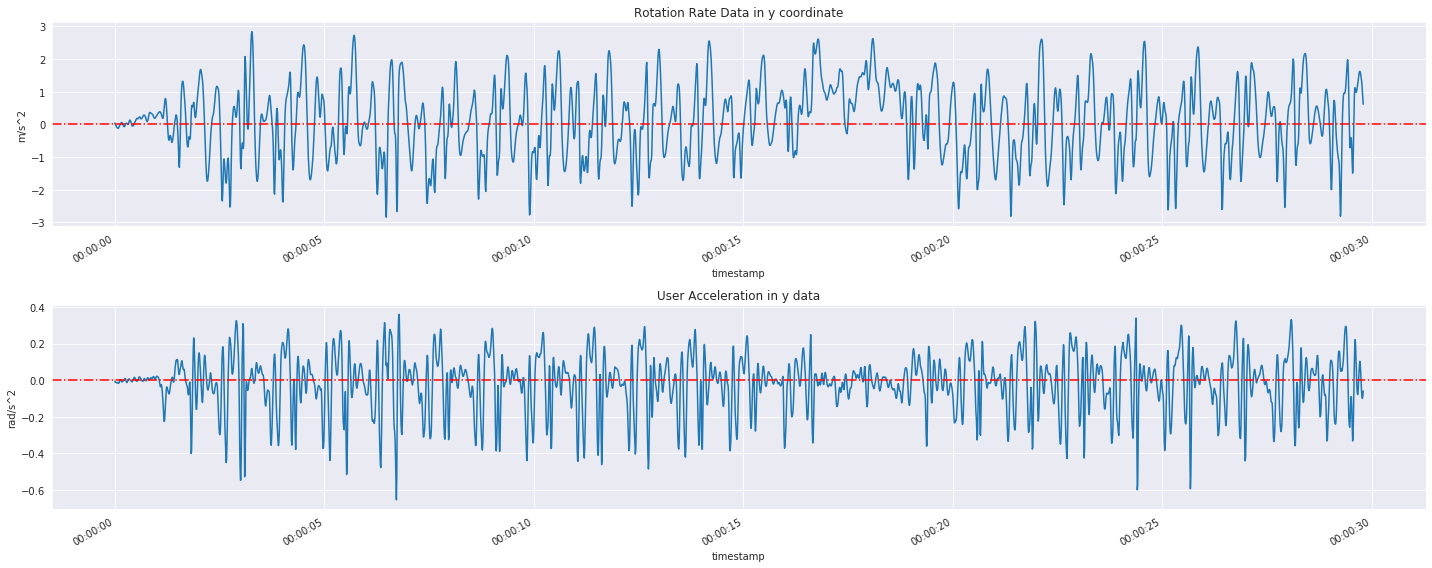

In [34]:
filepath = path_data["walk_motion.json_pathfile"].iloc[2]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")

fig, axes = plt.subplots(2, 1)

gyro["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
axes[0].set_title("Rotation Rate Data in y coordinate")
axes[0].set_ylabel("m/s^2")
axes[0].axhline(0, linestyle = "-.", color = "r")

accel["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
axes[1].set_title("User Acceleration in y data")
axes[1].set_ylabel("rad/s^2")
axes[1].axhline(0, linestyle = "-.", color = "r")

fig.tight_layout()
fig.show()

#### a. One Rotation Demo

From the time-series data above, we can see that there are is a huge amount of increase on approximately the <b> 17th second </b>, ending on around the <b> 20th second </b>. This is an indication that a person is doing a rotational movement during the mPower Walking test. Thus, our goal is to isolate this sequence, so that we can take in some rotational features, as well as an unbiased features on the walking tests.

Per the reseach paper published by [name], to recognize rotational movement, here are the steps that we are going to implement for our own gait signal QC pipeline:
<b>
- Apply low-pass filter into the signal data
- Detect zero crossing occurences on the time-series data, and separate the data
- On each period separated by the zero crossing, calculate the AUC of the period to get radians
- Using AUC during the particular period, multiply by duration (radians.secs)
- A threshold will be done distinguish rotation. A particular metrics established by the research paper shows that the AUC * duration during a period of zero crossing that is above 2 is a good metric for detecting a user rotation. 
</b>

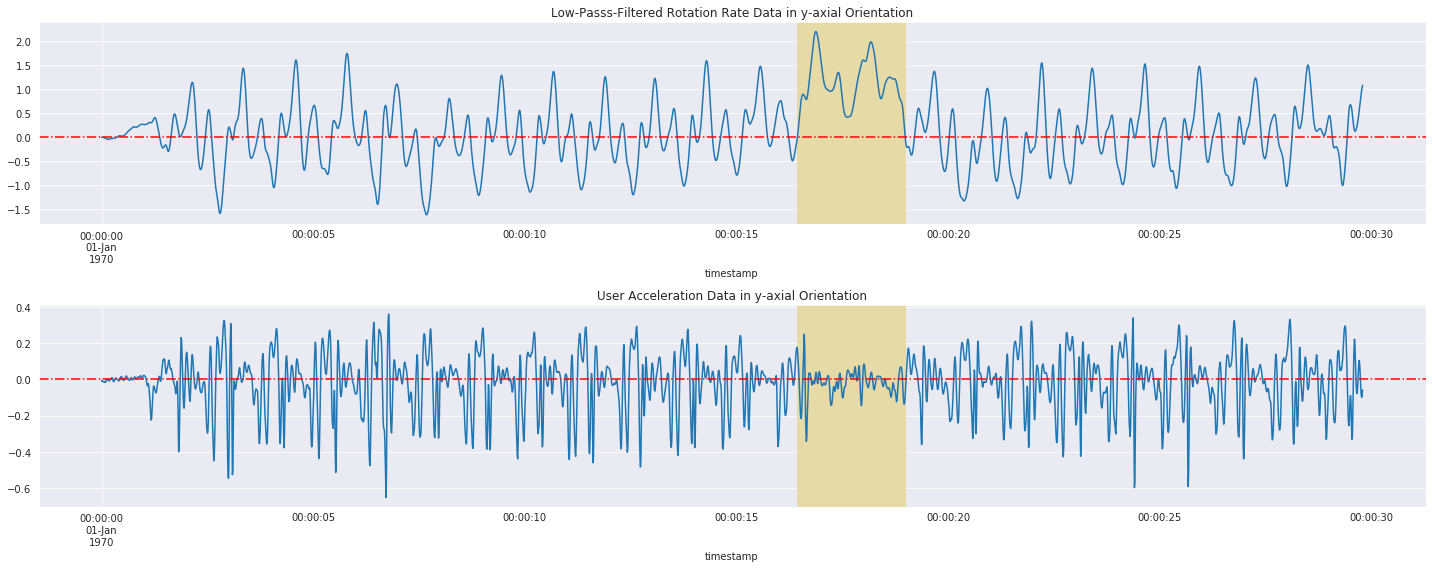

In [35]:
filepath = path_data["walk_motion.json_pathfile"].iloc[2]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot_rotation(accel,gyro)

As seen from this signal visualization above, notice the abnormalities that occured in the signal acceleration plot. During a rotation sequence, most of the user acceleration magnitude suddenly gets lower in comparison to the cyclical pattern that it demonstrated several seconds prior. 

#### b. Multiple Rotation Demo

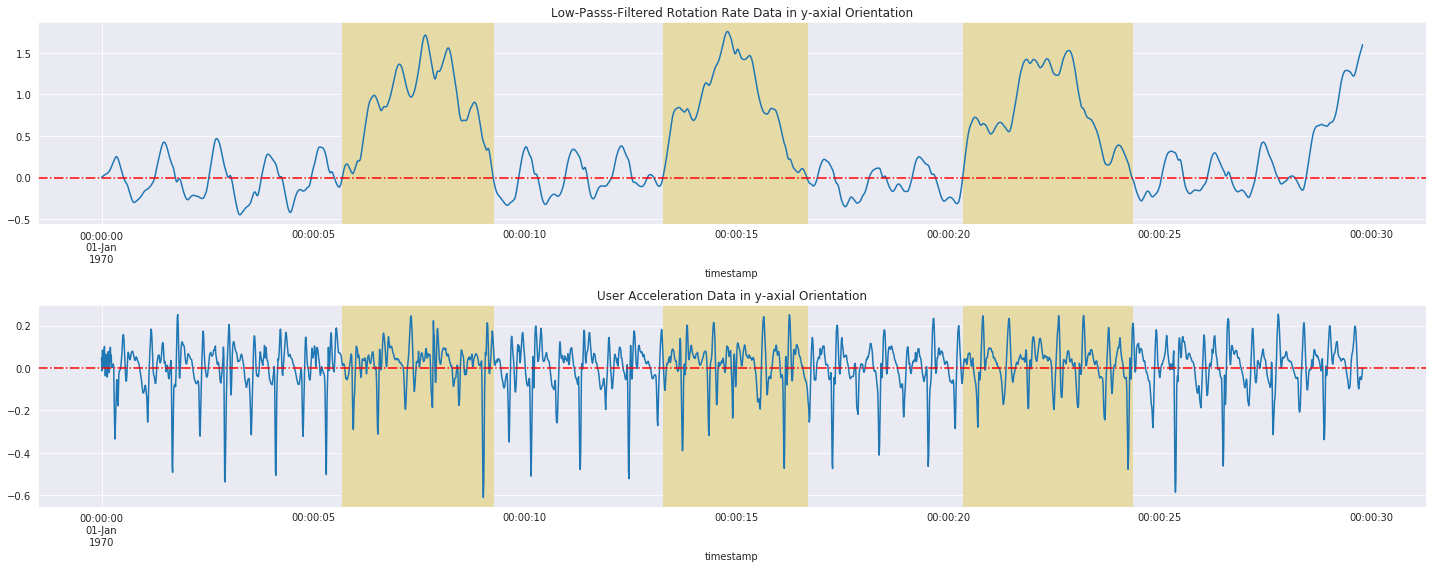

In [362]:
filepath = path_data["walk_motion.json_pathfile"].iloc[-2]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot_rotation(accel,gyro)

As seen from the picture above, we are able to retrieve 3 rotation sequence from this data, although not as apparent as the ones from the first demo, it might be caused due to the amount of radians being done by the users, the users might just did little turns, or it might be the computation itself that is oversensitive towards any kind of body turns. This might be a thing that we can improve in future implementations. 

## 2. Segmenting Rest Motion 

#### a. Walking Activity

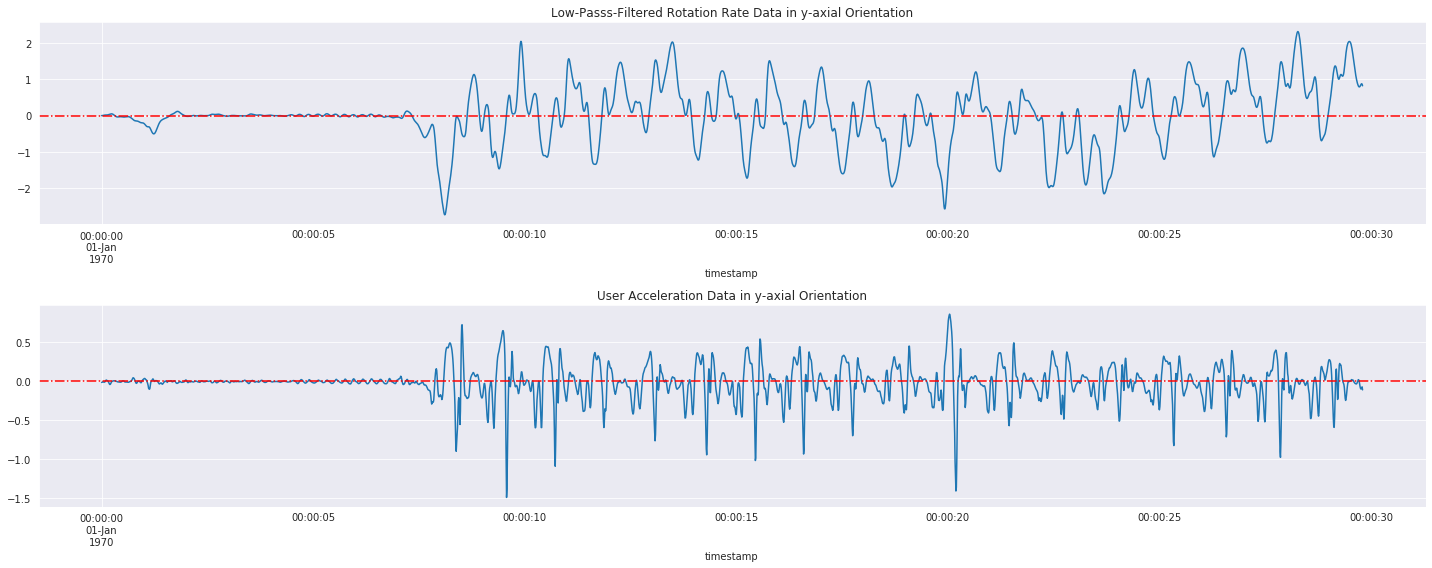

In [365]:
filepath = path_data["walk_motion.json_pathfile"].iloc[0]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot_rotation(accel,gyro)

In this graph we can see that the first 7 seconds is a clear indication that user is not doing the test like they are supposed to, which is a QC that we might require whenever we are trying to assess any features that uses heel strikes/steps as their basis of analysis. Having this QC might be useful as well to infer passive data filters to see whether our users are actually walking.

In [378]:
data = pd.DataFrame(gf.run_gait_feature_pipeline(filepath))
feat_cols = [feat for feat in data.columns if ("cadence" in feat) 
     or ("y_energy_freeze_index" in feat) or ("rotation_omega" in feat) or ("inferred_activity" in feat)]
data[feat_cols]

,AA_cadence,rotation_omega,x_cadence,y_cadence,y_energy_freeze_index,z_cadence
0,0.195680,NaN,0.391359,0.587039,8.548028,0.195680
1,0.000000,NaN,1.565435,0.978397,7.315892,1.565435
2,0.000000,NaN,2.739509,0.000000,14.886891,1.956792
3,0.000000,NaN,0.000000,1.174074,1.817710,0.195679
4,0.000000,NaN,0.391358,0.391358,1.642285,0.391358
5,0.000000,NaN,0.391358,0.587036,1.733668,0.782715
6,0.587036,NaN,0.782715,0.978393,1.706472,1.174072
7,0.391357,NaN,1.174071,1.174071,1.580710,1.369750
8,0.587035,NaN,1.174070,1.174070,1.308476,1.565427
9,0.782713,NaN,1.174069,0.978391,1.386624,1.369747


From the dataframe above, the cadence assessed from the resultant signal is zeroes out if a user is not doing their tests properly. And you can see that it is highly likely that user that is resting is having a very high energy in freeze index, which may create some mixed up with user that has PD (which usually have freeze index during walking motion itself)

### b. Annotating the sequences

In [381]:
data["recordId"] = "198459e0-6066-45ec-ade5-18b55c10cbb8"
data["test_type"] = "walking"
data = annotate_sequence(data)
feat_cols = [feat for feat in data.columns if ("y_cadence" in feat) 
     or ("y_energy_freeze_index" in feat)  
             or ("inferred_activity" in feat) or ("window" in feat)]
data[feat_cols]

,window,window_size,y_cadence,y_energy_freeze_index,inferred_activity
0,window_1,5.110394,0.587039,8.548028,walking
1,window_2,5.110400,0.978397,7.315892,not_walking
2,window_3,5.110405,0.000000,14.886891,not_walking
3,window_4,5.110409,1.174074,1.817710,not_walking
4,window_5,5.110411,0.391358,1.642285,not_walking
5,window_6,5.110415,0.587036,1.733668,not_walking
6,window_7,5.110419,0.978393,1.706472,walking
7,window_8,5.110422,1.174071,1.580710,walking
8,window_9,5.110427,1.174070,1.308476,walking
9,window_10,5.110432,0.978391,1.386624,walking


As seen from the dataframe above, we are able to annotate the walking data with inferred activity. However, there are still a misclassified inferred activity in the frist window due to some little fluctuation, that might be cause by a noise. However, this segmentation using zero cadence has at least become make our model become more susceptible towards users not doing their test. 

## 3. Why Segmentation?

For example, given a walking test that looks like the accelerometer signal below, we can see that the first 5 seconds is obvious that the person is not doing the test. 

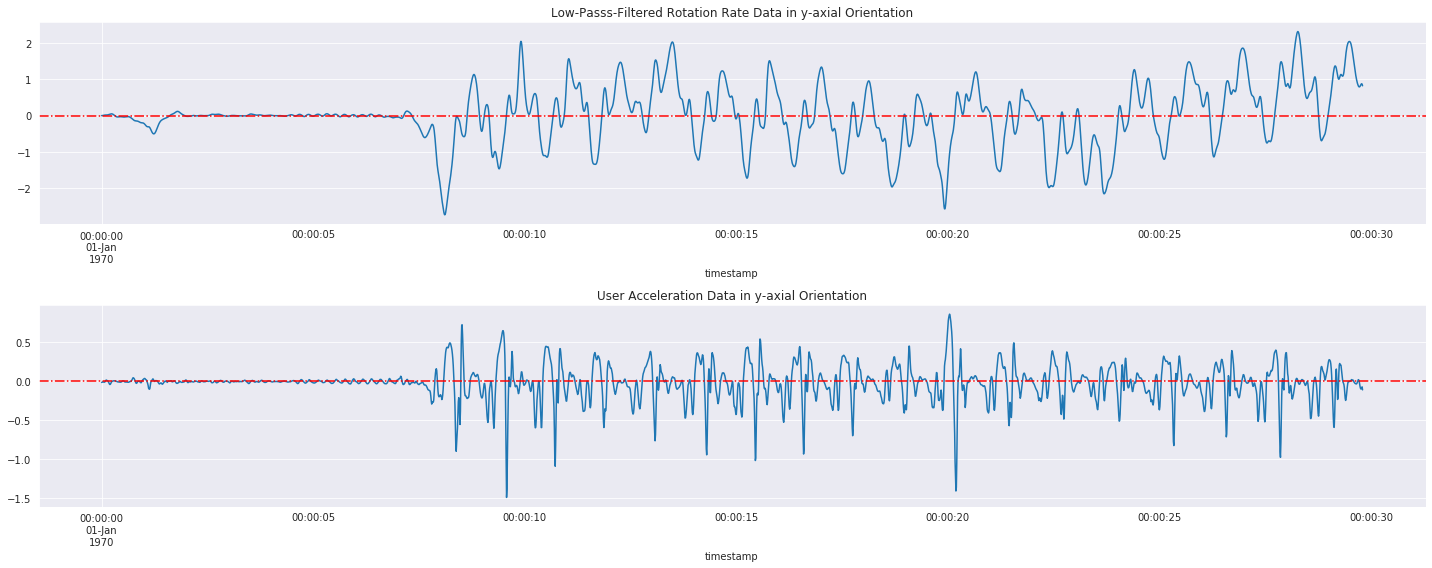

In [332]:
filepath = path_data["walk_motion.json_pathfile"].iloc[0]
gyro = gf.get_sensor_data(filepath, "rotationRate")
accel = gf.get_sensor_data(filepath, "userAcceleration")
plot_rotation(accel,gyro)

### Difference of before-after segmentation on non-walking

In [334]:
annotated = annotate_sequence(data)
annotated = annotated[annotated["inferred_activity"] == "walking"]

In [377]:
print("### Approximated Cadence in y-axis ### \n")
print("Taking all data sequence: %s steps/secs"%data["y_cadence"].mean())
print("Segment only walking sequence: %s steps/secs \n"%annotated["y_cadence"].mean())
print("### Energy Freeze Index in y-axis ### \n")
print("Taking all data sequence: %s"%data["y_energy_freeze_index"].mean())
print("Segment only walking sequence: %s \n"%annotated["y_energy_freeze_index"].mean())

### Approximated Cadence in y-axis ### 

Taking all data sequence: 0.915893059166009 steps/secs
Segment only walking sequence: 0.9883230393913678 steps/secs 

### Energy Freeze Index in y-axis ### 

Taking all data sequence: 2.637511324868763
Segment only walking sequence: 1.9270668607553425 



From the results above, we can see that there are difference in cadence and energy of freeze index (most prominent). Without segmentation cadence is underesimated and freeze of gait is overestimated (very high value if user is not moving). Thus by creating segmentation, it gives us a better approximation of the feature. Albeit not having that much of a difference, if this issue is not fixed, we would not have the right approximation on the features that we would like to model and analyze in the future. 